In [5]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import openmatrix as omx

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2018\OMX\nmskims.omx'
SKIM_TABLE = 'DIST'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

DISC_PURPS = ['social', 'eatout', 'othdiscr']

# Read model data
tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))
per = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))

obs_joint_tour_len = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "tourDistProfile_vis.csv")) #.rename(columns = {'freq': 'ObsN'})

omx_file = omx.open_file(SKIM_PATH, 'r')
dist_skim = np.array(omx_file[SKIM_TABLE])
omx_file.close()

nm_tours = tours[tours['tour_category'] == 'non_mandatory'].copy()
nm_tours['distance'] = ((dist_skim[nm_tours['origin'].astype(int) - 1, nm_tours['destination'].astype(int) - 1]).astype(int) + 1).clip(0, 41)
nm_tours['PURPOSE'] = 'imain'
nm_tours.loc[nm_tours['tour_type'].isin(DISC_PURPS), 'PURPOSE'] = 'idisc'

model_tour_len_freq = nm_tours.groupby(['PURPOSE', 'distance']).agg(freq = ('person_id', 'count')).reset_index()

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_4424\1744647458.py:31: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))


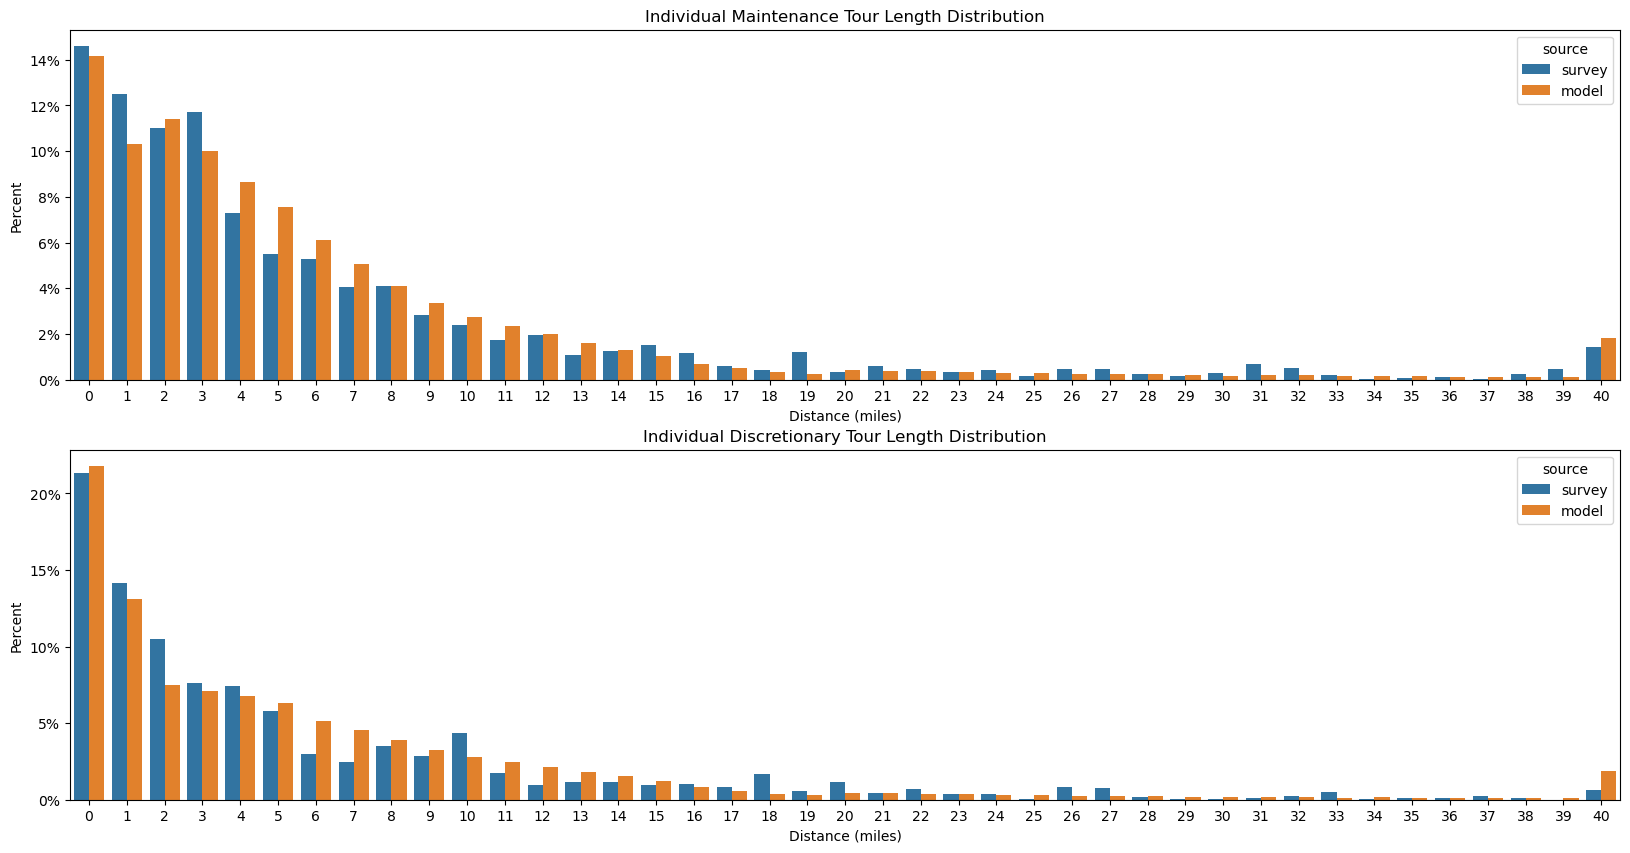

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_idx = 210
count = 1
purp_labels = {'imain': 'Maintenance', 'idisc': 'Discretionary'}
for purp in ['imain', 'idisc']:
    plot_data = pd.concat([obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == purp].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[model_tour_len_freq['PURPOSE'] == purp].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')])
    plot_data['distance'] = plot_data['distance'] - 1
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'distance', y = 'percent', hue = 'source')
    plt.title(f"Individual {purp_labels[purp]} Tour Length Distribution")
    # plt.xticks(fontsize=16, rotation = 90)
    # plt.yticks(fontsize=16)
    plt.ylabel('Percent')
    plt.xlabel('Distance (miles)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1

In [ ]:
for purp in ['imain', 'idisc']:
    x = obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == purp].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum())
    y = model_tour_len_freq[model_tour_len_freq['PURPOSE'] == purp].assign(percent = lambda x: x['freq'] / x['freq'].sum())
    cr = x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').min(1).sum() / x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').max(1).sum()
    print(f"Purpose: {purp}, obs ATF: {np.average(x.distance, weights = x.freq):0.2f}, mod ATF: {np.average(y.distance, weights = y.freq):0.2f}, coincidence ratio = {cr:0.2f}")


Purpose: imain, obs ATF: 7.62, mod ATF: 7.33, coincidence ratio = 0.84
Purpose: idisc, obs ATF: 6.86, mod ATF: 7.10, coincidence ratio = 0.79


# Adjust Individual Non-Mandatory Tours

In [ ]:
# Maint adjustments
purp = 'imain'
adjust_data = pd.concat([obs_joint_tour_len[(obs_joint_tour_len['PURPOSE'] == purp) & (obs_joint_tour_len['distbin'] > 0) & (obs_joint_tour_len['distbin'] <= 20)].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[(model_tour_len_freq['PURPOSE'] == purp) & (model_tour_len_freq['distance'] > 0) & (model_tour_len_freq['distance'] <= 20)].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')]).pivot(index = 'distance', columns = 'source', values = 'percent').reset_index()

adjust_data['distance'] = adjust_data['distance'] - 0.5
adjust_data['adjustment'] = np.log(adjust_data['survey'] / adjust_data['model'])
adjust_data


res1 = sm.OLS(endog = adjust_data['adjustment'], exog = adjust_data['distance']).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.160
Model:                            OLS   Adj. R-squared (uncentered):              0.116
Method:                 Least Squares   F-statistic:                              3.612
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                      0.0727
Time:                        06:53:47   Log-Likelihood:                         -9.4981
No. Observations:                  20   AIC:                                      21.00
Df Residuals:                      19   BIC:                                      21.99
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0147      0.008      1.900      0.073      -0.001       0.031
==============================================================================
Omnibus:                       24.179   Durbin-Watson:                   0.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.448
Skew:                           2.055   Prob(JB):                     7.38e-09
Kurtosis:                       8.295   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
adjust_data

source,distance,model,survey,adjustment
0,0.5,0.151217,0.158192,0.045094
1,1.5,0.110332,0.135739,0.207244
2,2.5,0.121836,0.119491,-0.019433
3,3.5,0.107201,0.127103,0.170291
4,4.5,0.092378,0.079015,-0.156247
5,5.5,0.080887,0.059599,-0.305408
6,6.5,0.065236,0.057093,-0.133327
7,7.5,0.054337,0.043942,-0.212333
8,8.5,0.043946,0.044399,0.010252
9,9.5,0.035788,0.030523,-0.159123


In [ ]:
# Disc adjustments
purp = 'idisc'
adjust_data = pd.concat([obs_joint_tour_len[(obs_joint_tour_len['PURPOSE'] == purp) & (obs_joint_tour_len['distbin'] > 1) & (obs_joint_tour_len['distbin'] <= 20)].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[(model_tour_len_freq['PURPOSE'] == purp) & (model_tour_len_freq['distance'] > 1) & (model_tour_len_freq['distance'] <= 20)].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')]).pivot(index = 'distance', columns = 'source', values = 'percent').reset_index()

adjust_data['distance'] = adjust_data['distance'] - 0.5
adjust_data['adjustment'] = np.log(adjust_data['survey'] / adjust_data['model'])
adjust_data


res1 = sm.OLS(endog = adjust_data['adjustment'], exog = adjust_data['distance']).fit()
res1.summary()

c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.026
Model:                            OLS   Adj. R-squared (uncentered):             -0.028
Method:                 Least Squares   F-statistic:                             0.4877
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                       0.494
Time:                        06:53:47   Log-Likelihood:                         -14.201
No. Observations:                  19   AIC:                                      30.40
Df Residuals:                      18   BIC:                                      31.35
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0071      0.010      0.698      0.494      -0.014       0.028
==============================================================================
Omnibus:                        4.999   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                2.675
Skew:                           0.790   Prob(JB):                        0.263
Kurtosis:                       3.938   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
adjust_data

source,distance,model,survey,adjustment
0,1.5,0.182944,0.197115,0.074609
1,2.5,0.104344,0.146509,0.339389
2,3.5,0.099283,0.106032,0.065762
3,4.5,0.094291,0.103995,0.097958
4,5.5,0.087957,0.080436,-0.089390
5,6.5,0.071875,0.041884,-0.540025
6,7.5,0.063747,0.034486,-0.614370
7,8.5,0.054078,0.048956,-0.099504
8,9.5,0.045553,0.039459,-0.143613
9,10.5,0.039014,0.060570,0.439876
